# Extracción de contenido (*scraping*) con el lenguaje de programación Python

<html><p><span style="font-size:x-small">En GitHub, los enlaces de la tabla de contenidos de yb notebook Jupyter no funcionan. Para una versión con enlaces, abrir en <a href="https://nbviewer.org/github/HD-aula-Literatura/II-2-scraping/blob/main/02-extraccion-con-python/01-extraccion-desde-html.ipynb" target="_blank">NbViewer</a>. Para una versión interactiva del notebook, abrir en Binder:</span></p></html>

[![badge](https://img.shields.io/badge/abrir-binder-579ACA.svg?logo=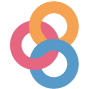)](https://mybinder.org/v2/gh/HD-aula-Literatura/II-2-scraping/374e6a2de8d63642813cfd4aefe3ed7cc8fde722?urlpath=lab%2Ftree%2F02-extraccion-con-python%2F01-extraccion-desde-html.ipynb)


- [Introducción](#intro)
- [Extracción de un poema dado su URL](#extraccion-poema-indiv)
    - [Bajar el contenido de un URL](#bajar-url)
    - [Extraer el contenido](#extraer-contenido)
        - [Obtener los metadatos](#metadatos-indiv)
        - [Obtener el texto del poema](#texto-indiv)
    - [Escribir la información extraída en archivos de salida](#salida-archivo)
- [Extracción de múltiples poemas a partir de una lista de URLs](#extraccion-poema-multiple)
    - [Crear la lista de URLs](#crear-lista-urls)
    - [Bajar el contenido](#bajar-lista-urls)
    - [Extraer la información](#extraer-contenido-multiple)
    - [Guardar los resultados](#salida-archivos)
        - [Guardar en dataframe con todos los textos y metadatos](#salida-archivos-dataframe)
        - [Guardar el texto en un archivo por poema y crear un archivo global de metadatos](#salida-archivos-indiv-plus-metadatos)
    - [Guardar el HTML original en archivos](#guardar-html)
        - [Crear los árboles HTML a partir de los archivos guardados](#crear-html-desde-archivo)


<a name="intro"></a>
# Introducción

Veremos cómo efectuar las operaciones siguientes:

- Bajar el contenido (en HTML) de uno o varios URL
- Analizar (parsing) el HTML de forma automática para extraer el contenido de las etiquetas que nos interesan
- Crear archivos de salida con la información extraída y archivos de entrada con información a explotar para la extracción

<html><!--
%TODO% añadir información sobre cómo usar un notebook Jupyter
-->
</html>

<a name="extraccion-poema-indiv"></a>
## Extraer el contenido y metadatos de un poema, dado sur URL

Esta tarea corresponde a lo realizado con OpenRefine en la sección 4.1 del capítulo.

<a name="bajar-url"></a>
### Bajar el contenido de un URL

Para bajar el contenido usamos la biblioteca (conjunto de instrucciones que podemos utilizar desde código Python) [requests](https://requests.readthedocs.io/en/latest/)

En caso de que la biblioteca no esté instalada (lo cual se verá ya que, al intentar usarla, habrá un mensaje de error que lo indique), se puede instalar con `pip install requests` (ver [documentación](https://requests.readthedocs.io/en/latest/))

En el código siguiente, se siguen varias etapas:
- importamos los paquetes o bibliotecas a utilizar
- el URL se asigna, como cadena de caracteres (entre comillas), a una variable llamada `url_pagina` 
- hacemos una petición para obtener el contenido de la página, con `requests.get()`
- obtenemos una respuesta, asignada a la variable `respuesta`. Esta respuesta tiene propiedades interesantes, como las siguientes
  - `.status_code`, que será 200 si el contenido se ha bajado correctamente, u otro código (p. ej. 404 o 500) en caso de error
  - `.text`: devuelve una cadena de texto que representa el contenido de la página. En este caso se trata de contenido HTML (una cadena de texto que representa el HTML de la página).
- Asignamos el contenido de la página (`respuesta.text`) a la variable `html_pagina`. Necesitamos este contenido para crear el árbol HTML que explotaremos para la extracción

In [125]:
import requests
url_pagina = "https://es.wikisource.org/wiki/Una_vi%C3%B1eta"
respuesta = requests.get(url_pagina)
html_pagina = respuesta.text

<a name="extraer-contenido"></a>
### Extraer el contenido

Usaremos el árbol HTML para esto. Ya vimos este tipo de enfoque, con OpenRefine, cuyo lenguaje [GREL](https://docs.openrefine.org/manual/grelfunctions) tiene une instrucción `parseHtml()` para crear el árbol

Con Python, para crear el árbol HTML y extraer el contenido, utilizaremos la "biblioteca" [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/), ampliamente utilizada. Etapas:

- Importamos la biblioteca, con la instrucción `from bs4 import BeautifulSoup`
- En caso de que la biblioteca no esté instalada (lo cual se verá ya que, al intentar usarla, habrá un mensaje de error que lo indique), se puede instalar con `pip install beautifulsoup4` (ver [documentación](https://www.crummy.com/software/BeautifulSoup/bs4/doc/))
- Creamos el árbol HTML a partir de la cadena de texto que lo representa (obtenida más arriva), con `BeautifulSoup(html_pagina)`

Nota: Es habitual llamar "soup" o "sopa" a la representación de contenido HTML analizado con una biblioteca (BeautifulSoup en Python, [JSoup](https://jsoup.org/apidocs/org/jsoup/select/Selector.html) en Java; por cierto OpenRefine en tanto que herramienta creada en Java usa JSoup)

In [126]:
from bs4 import BeautifulSoup
arbol = BeautifulSoup(html_pagina)

<a name="metadatos-indiv"></a>
#### Obtener los metadatos

Una vez que el árbol está disponible, podemos extraer información basándonos en el nombre y atributos de los elementos, como hicimos con OpenRefine en el capítulo.

- Para el elemento de la autora, buscaremos un elemento `<span class='ws-author'>` (es decir, un elemento `span` con un atributo `class` cuyo valor es `ws-author`).

- Para el elemento del título, buscaremos un elemento `<span class='ws-title'>` (es decir, un elemento `span` con un atributo `class` cuyo valor es `ws-title`).

Para hacer esta búsqueda, podemos usar el método `find_all()`, disponible a partir del objeto árbol (que está asignado a la variable `arbol`). Hay varias formas posibles de proceder (ver [documentación](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#find-all)), pero una manera genérica es la siguiente:

```python
arbol.find_all("span", attrs={"class": 'ws-title'})
``` 
Como se ve en el ejemplo, como argumentos a `find_all()` se da el nombre del elemento, y después la sequencia `attrs=` seguida del nombre y valor del atributo buscado, respetando la sintaxis del ejemplo (cadenas entrecomilladas separadas por el signo dos puntos)

<html><!--Comentario si usamos class_ Cabe mencionar que la clave de búsqueda no es `class` sino `class`, ya que la palabra *class* ya tiene otra utilización en Python.--></html> 

Asignaremos el resultado de cada búsqueda a una variable.

In [127]:
autora_ele = arbol.find_all("span", attrs={"class": "ws-author"})
titulo_ele = arbol.find_all("span", attrs={"class": "ws-title"})

Si miramos el contenido de las variables, veremos que, como pasaba con `select()` en las consultas de HTML en OpenRefine, `find_all()` devuelve una lista de valores.

Podemos examinar el contenido de las variables simplemente escribiendo su nombre en una celda de notebook Jupyter o en una consola de Python, o con la función `print()`, pasándole el nombre de la variable como argumento.

In [128]:
# comentario: escribir nombre de variable para ver su valor
autora_ele

[<span class="ws-author">Delmira Agustini</span>]

In [129]:
# ver valor de una variable con print()
print(autora_ele)

[<span class="ws-author">Delmira Agustini</span>]


En tanto que listas, accederemos a su contenido con índices numéricos, y se empieza a contar por cero: `autora_ele[0]`.

Como pasaba con OpenRefine, como salida de nuestro procesamiento no queremos un "elemento", un "nodo" de un árbol con propiedades útiles para su análisis con funciones de manipulación del árbol, sino una cadena de texto. Para esto, podemos usar el método `get_text()` de los elementos tal que analizados por BeautifulSoup. 

In [130]:
autora = autora_ele[0].get_text()
titulo = titulo_ele[0].get_text()

Si inspeccionamos el contenido de las variables con `print()`, veremos que ahora sí contienen una cadena de texto con la información deseada

In [131]:
print(autora)
print(titulo)

Delmira Agustini
Una viñeta


<a name="texto-indiv"></a>
#### Obtener el texto del poema

Pasamos a la extracción del texto. Hay varias formas de hacer esto, algunas muy compactas. Usamos aquí una manera de hacerlo similar a lo que se hizo en el capítulo con OpenRefine.

Se trata de identficar elementos `<div class='poem'>`. Podríamos usar la misma sintaxis que antes, que era `arbol.find_all("div", attrs={"class":"poem"}`, pero cuando el atributo con el que trabajamos es `class`, podemos usar una sintaxis abreviada, como en el ejemplo.

Además de `find_all()`, que devuelve una lista, también hay un método `find()` que devuelve directamente un elemento en vez de una lista. Vamos a usarlo esta vez.

In [132]:
poema_div = arbol.find("div", "poem")

In [133]:
print(poema_div)

<div class="poem">
<p> Tarde sucia de invierno. El caserío,   <br/>
 como si fuera un croquis al creyón,   <br/>
 se hunde en la noche. El humo de un bohío,   <br/>
 que sube en forma de tirabuzón;   <br/>
 <br/>
<br/>
 mancha el paisaje que produce frío,  <br/>
 y debajo de la genuflexión   <br/>
 de la arboleda, somormuja el río   <br/>
 su canción, su somnífera canción.   <br/>
 <br/>
<br/>
 Los labradores, camellón abajo,   <br/>
 retornan fatigosos del trabajo,  <br/>
 como un problema sin definición.   <br/>
 <br/>
<br/>
 Y el dueño del terruño, indiferente,   <br/>
 rápidamente, muy rápidamente,   <br/>
 baja en su coche por el camellón.
</p>
</div>


No hemos llegado todavía al elemento que contiene el poema, que es en realidad un `<p>` bajo el `<div class='poem'>`. Una manera fácil de hacerlo es con el método `find()` de nuevo.

In [134]:
poema_ele = poema_div.find("p")

Para obtener el texto, existe el método `get_text()`. Devuelve el texto como una cadena. A partir del resultado, lo vamos a dividir en versos usando un salto de línea y también vamos a eliminar espacios en blanco de los extremos de cada verso (como hicimos con OpenRefine).

El método para elminiar espacios en blanco de los extremos de una cadena en Python es `strip()` (similar a `trim()` en OpenRefine). También hay `rstrip()` para quitar espacios sólo del final o `lstrip()` par quitar espacios sólo del principio.

Usamos `strip()` dentro de un constructo llamado *comprensión de lista* o *list comprehension*. Como un bucle de tipo *for each* (visto en el capítulo), permite recorrer una secuencia usando una variable que sirve para iterar sobre la secuencia (`verso` en el ejemplo).

Para escribir el resultado en un archivo, vamos a crear una cadena con `"\n".join()`, que concatena los elementos de la lista `texto_versos_limpio` usando un salto de línea como separador. (La sintaxis es diferente a OpenRefine, donde se da como argumento el separador `.join("\n")` en vez de la lista a concatenar).

In [135]:
texto_poema_bruto = poema_ele.get_text()
#arbol.select("div[class=poem] > p")
texto_versos = texto_poema_bruto.split("\n")
texto_versos_limpio = [verso.strip() for verso in texto_versos]
texto_final = "\n".join(texto_versos_limpio)

In [136]:
print(texto_versos_limpio)
print(texto_final)

['Tarde sucia de invierno. El caserío,', 'como si fuera un croquis al creyón,', 'se hunde en la noche. El humo de un bohío,', 'que sube en forma de tirabuzón;', '', '', 'mancha el paisaje que produce frío,', 'y debajo de la genuflexión', 'de la arboleda, somormuja el río', 'su canción, su somnífera canción.', '', '', 'Los labradores, camellón abajo,', 'retornan fatigosos del trabajo,', 'como un problema sin definición.', '', '', 'Y el dueño del terruño, indiferente,', 'rápidamente, muy rápidamente,', 'baja en su coche por el camellón.', '']
Tarde sucia de invierno. El caserío,
como si fuera un croquis al creyón,
se hunde en la noche. El humo de un bohío,
que sube en forma de tirabuzón;


mancha el paisaje que produce frío,
y debajo de la genuflexión
de la arboleda, somormuja el río
su canción, su somnífera canción.


Los labradores, camellón abajo,
retornan fatigosos del trabajo,
como un problema sin definición.


Y el dueño del terruño, indiferente,
rápidamente, muy rápidamente,
baja 

Nota: Habría una manera compacta de conseguir el texto del poema, usando el método `select()`, cuyo argumento es un selector (una expresión para identificar un conjunto de nodos en un árbol HTML) que identifica los elementos `<p>` que son un hijo directo de un elemento `<div class="poem">`, gracias al operador `>` que significa *hijo directo*:  

```python
arbol.select("div[class=poem] > p")[0].get_text()
```

<a name="salida-archivo"></a>
### Escribir la información extraída en archivos de salida

Vamos a escribir el poema y sus metadatos en un archivo de salida.

Una opción útil es crear un archivo delimitado (CSV, TSV, o de tipo hoja de cálculo). Para esto, se puede usar la biblioteca pandas.

Crearemos una estructura de datos llamada dataframe, con las etapas siguientes:

- El formato a utilizar se ve en la variable `datos`. Se declaran los nombres de las columnas, y, para cada columna, una lista con sus valores (ya hemos visto que los corchetes se suelen usar para representar listas entre otros usos).
- Una vez que los datos están listos, el método `DataFrame` de la biblioteca pandas crea el objeto, con lo que `pd.DataFrame(datos)` crea la dataframe, que se ha asignado a una variable con nombre `df`.

In [137]:
import pandas as pd

datos = {"autora": [autora],
         "titulo": [titulo],
         "textoPoema": [texto_final]} 

df = pd.DataFrame(datos)

In [138]:
df

,autora,titulo,textoPoema
0,Delmira Agustini,Una viñeta,"Tarde sucia de invierno. El caserío,\ncomo si ..."


Vamos a escribir los resultados en archivos de salida con distintos formatos, aprovechando las posibilidades de pandas.

Para crear las rutas (la localización en el disco de cada archivo) usamos el módulo `pathlib`. 

- Se obtiene el directorio donde reside este notebook con `pathlib.Path.cwd()`
- A partir de ahí, se crea el resto de la ruta con `.joinpath()`. Cada etapa de la ruta (cada directorio y el archivo final) se da como argumento  

In [139]:
import pathlib

directorio_actual = pathlib.Path.cwd()
dir_resultados = directorio_actual.joinpath("resultados", "desde-html")
nombre_fichero = "agustini_poema"
salida_csv = dir_resultados.joinpath(nombre_fichero + ".csv")
salida_tsv = dir_resultados.joinpath(nombre_fichero + ".tsv")
salida_excel = dir_resultados.joinpath(nombre_fichero + ".xlsx")

Con las instrucciones anteriores hemos creado una representación de las rutas de los archivos de salida, pero no los archivos en sí, ni tampoco los directorios (*resultados*, *desde-html*).

Si los directorios no existen, los podemos crear con `.mkdir(parents=True)` (si ya existen, esta instrucción dará un error). La opción `parents=True` crea también directorios intermedios en caso de que parte de la ruta no exista.

Para no ejecutar la instrucción, dejar la celda sin ejecutar o comentar la instrucción prefijando el signo `#`, con lo que será ignorada.

In [140]:
#dir_resultados.mkdir(parents=True)

Para escribir el contenido de las dataframes a los archivos, usamos métodos disponibles desde el objeto dataframe, que aquí se ha llamado `df` (es un nombre habitual).
- El método `to_csv()` escribe archivos delimitados por comas, a no ser que se le dé el argumento `sep="\t"` en cuyo caso utilizará tabulaciones como delimitador (lo que se llama a veces archivo TSV en vez de CSV). Tanto los CSV como los TSV se pueden abrir fácilmente con LibreOffice Calc o con Excel
- El método `to_excel()` crea archivos en formato XLSX (Excel)
- La opción `index=False` se usa ya que de lo contrario, pandas añade una primera columna con el número de fila, lo cual no es informativo para lo que estamos haciendo


In [141]:
df.to_csv(salida_csv, index=False)
df.to_csv(salida_tsv, sep="\t", index=False)
df.to_excel(salida_excel, index=False)

Al abrir los resultados con una hoja de cálculo (en este caso LibreOffice Calc), se ven así:

|tsv|xlsx|
| :---: | :---: |
|![imagen](./img/02_html_01_tsv.png)|![imagen](./img/02_html_02_excel.png)|


<a name="extraccion-poema-multiple"></a>
# Extracción de múltiples poemas a partir de una lista de URLs

Usamos el mismo ejemplo que en el capítulo, los poemas de Alfonsina Storni en Wikisource: [https://es.wikisource.org/wiki/Autor:Alfonsina_Storni](https://es.wikisource.org/wiki/Autor:Alfonsina_Storni)

Usaremos las mismas bibliotecas que en el ejemplo anterior sobre la [extracción de un poema individual](#extraccion-poema-indiv), y si no se han importado antes, habrá que importarlas.

In [142]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

<a name="crear-lista-urls"></a>
## Crear la lista de URLs

Crearemos primero una lista con los enlaces a los poemas.

Como se vio en el capítulo y como muestra la imagen siguiente, nos interesan los elementos `<a>` que son descendientes de elementos `<ul>`, si bien no todos los `<ul>` de la página nos interesan, ya que el primero (*Obras*) no contiene enlaces a poemas individuales.

![img](./img/02_html_03_firefox-dev-tools-ul-a.png)

In [143]:
url_inicial = "https://es.wikisource.org/wiki/Autor:Alfonsina_Storni"
respuesta = requests.get(url_inicial)
html_inicial = respuesta.text

Creamos un árbol con el contenido y extraemos los enlaces deseados, con BeautifulSoup. Podríamos hacerlo de forma más compacta (con menos líneas de código), pero usando instrucciones simples, se pueden seguir la siguientes etapas:

1. Se crea el árbol a partir de la cadena de texto que expresa el HTML bajado para la página, este árbol se asigna a la variable `arbol` (aunque, como para toda variable, cualquier otro nombre de variable válido en python sería posible)
1. Se declara una lista llamada `enlaces`, donde guardaremos los enlaces
1. Ya que los enlaces que nos interesan están dentro de listas no ordenadas (elementos `<ul>`), recuperamos todos los elementos `<ul>` de la página con `find_all("ul")`. De modo más exacto, no queremos todas los elementos `<ul>`, sino que queremos ignorar el primero. Por eso seleccionamos los miembros desde el segundo, con `[1:]` (el primer elemento lleva el índice 0, así que para seleccionar desde el segundo, se empieza por el índice 1. Para seleccionar hasta el final, en las listas de Python se puede usar `:`). Una vez seleccionados desde el segundo hasta el último `<ul>`, se asigna el resultado a la variable `elems_ul`.   
1. Un bucle recorre la lista `elems_ul`, usando `elem` como iterador para recorrerla. Es decir, el valor de `elem` corresponderá iterativamente a cada elemento de la lista, hasta terminar de recorrerla. Para cada elemento de la lista, buscamos todos los enlaces que este contiene, con `find_all("a")`. Como sabemos, `find_all()` devuelve una lista. Como vimos en el punto (2), tenemos ya una variable de tipo lista preparada para guardar los enlaces, se trata de la variable `enlaces`. Podríamos guardar el resultado de `find_all()` en esta lista, pero esto nos crearía listas anidadas (listas dentro de listas). Esto añade una complejidad que no es necesaria. Lo que vamos a hacer es añadir los miembros del resultado de `find_all()` directamente a `enlaces`. No la lista resultante, sino sus miembros. Para añadir a una lista A los miembros de otra lista B, la instrucción es `A.extend(B)`. Por eso usamos `enlaces.extend(elem.find_all("a")` dentro del bucle. 

In [144]:
arbol = BeautifulSoup(html_inicial)
enlaces = []
elems_ul = arbol.find_all("ul")[1:]
for elem in elems_ul:
    enlaces.extend(elem.find_all("a"))

In [145]:
enlaces

[<a href="/wiki/Agrio_est%C3%A1_el_mundo" title="Agrio está el mundo">Agrio está el mundo</a>,
 <a href="/wiki/Alma_desnuda" title="Alma desnuda">Alma desnuda</a>,
 <a href="/wiki/As%C3%AD" title="Así">Así</a>,
 <a href="/wiki/Aspecto" title="Aspecto">Aspecto</a>,
 <a href="/wiki/Buenos_Aires_(Storni)" title="Buenos Aires (Storni)">Buenos Aires</a>,
 <a href="/wiki/Calle" title="Calle">Calle</a>,
 <a href="/wiki/Carta_l%C3%ADrica_a_otra_mujer" title="Carta lírica a otra mujer">Carta lírica a otra mujer</a>,
 <a href="/wiki/Contra_voz" title="Contra voz">Contra voz</a>,
 <a href="/wiki/Date_a_volar" title="Date a volar">Date a volar</a>,
 <a href="/wiki/Dolor_(Storni)" title="Dolor (Storni)">Dolor</a>,
 <a href="/wiki/Dos_palabras" title="Dos palabras">Dos palabras</a>,
 <a href="/wiki/Dulce_tortura" title="Dulce tortura">Dulce tortura</a>,
 <a href="/wiki/El_canal" title="El canal">El canal</a>,
 <a href="/wiki/El_cisne_enfermo" title="El cisne enfermo">El cisne enfermo</a>,
 <a href="

Como vimos en el capítulo, algunos enlaces no se refieren a poemas. Vimos que se refieren a poemas los enlaces que cumplen tres condiciones:

1. contienen la expresión "/wiki/"
1. o bien no llevan atributo `class`, o bien, si lo llevan, su valor no es *mw-redirect*
1. su URL (en el atributo `href` del elemento `<a>` para el enlace) no corresponde a la expresión regular `:|Portada` (no puede contenir ni el signo dos puntos ni la palabra *Portada*; el operador `|` en la expresión significa una alternancia)

Ya que vamos a utilizar expresiones regulares o regex, debemos importar el módulo que permite usarlas en Python, llamado `re` (iniciales de *Regular Expression*), con `import re`.

El resto del código siguiente recorre la lista `enlaces` con un bucle `for`, usando un iterador para el que se ha elegido el nombre `enlace`, y verifica cada uno de los elementos `<a>` que esta contiene. Si el elemento cumple las condiciones, se guarda en otra lista declarada antes del bucle, llamada `enlaces_limpios`. El bucle sigue los pasos siguientes:

1. El atributo `href` de cada miembro de la lista inicial se asigna a la variable `enlace_url`. Para obtener el valor de un atributo (aquí, el atributo `href` de `enlace`), la sintaxis es `enlace["href"]` (también se puede usar la sintaxis `enlace.attrs["href"]`)
1. Varios tests (estructura `if ... elif ... else`) verifican las condiciones deseadas, siguiendo la sintaxis que se ve en el ejemplo.
  1. El primer test es `if "/wiki/" not in enlace_url`. Si la cadena no se encuentra en el `href` del elemento (asignado a `enlace_url`), el bucle pasa al elemento siguiente, con `continue`, sin mirar el resto de condiciones
  1. El segundo test es `elif "class" in enlace.attrs and enlace["class"][0] == "mw-redirect"`. Esto mira primero si `class` forma parte de los atributos del elemento, y, en ese caso, comprueba si el valor de `class` es *mw-redirect*. Los atributos se dan en una lista, por eso debemos hacer `[0]` en `enlace["class"][0]`. En caso afirmativo, debemos ignorar el elemento, con lo que `continue` hace que el bucle pase al siguiente elemento de la lista `enlaces`, sin mirar el resto de tests
  1. El tercer test verifica si el `href` corresponde a la expresión regular `:|Portada`, que describe los links que queremos evitar, con el método `search` del módulo `re`: `re.search(r":|Portada", enlace_url)`. Como se ve, la sintaxis consiste a pasar como primer argumento la expresión regular, entre comillas y precedida de `r`, y como segundo argumento la cadena de texto en la que hay que buscar la expresión, en este caso `enlace_url`. Si el texto del link corresponde a la regex, el bucle pasa al siguiente elemento, con `continue`
1. Después de hacer los tests para cada elemento, el bucle llega a la parte `else`. Si el bucle llega hasta aquí para un elemento, quiere decir que el elemento cumple las condiciones de los links que queremos guardar. Por esta razón, añadimos este link a la lista `enlaces_limpios` con la instrucción `append()` que sirve para añadir un miembro a una lista, sin olvidar prefijar la cadena https://es.wikisource.org que forma parte del link necesario para bajar los poemas, pero que estaba omitida en los atributos `href`

In [146]:
import re

enlaces_limpios = []

for enlace in enlaces:
    enlace_url = enlace["href"]
    if "/wiki/" not in enlace_url:
        continue
    elif "class" in enlace.attrs and enlace["class"][0] == "mw-redirect":
        continue
    elif re.search(r":|Portada", enlace_url):
        continue
    else:
        enlaces_limpios.append("https://es.wikisource.org" + enlace_url)

Podemos comprobar que esta lista solo contiene links a poemas individuales:

In [147]:
enlaces_limpios

['https://es.wikisource.org/wiki/Agrio_est%C3%A1_el_mundo',
 'https://es.wikisource.org/wiki/Alma_desnuda',
 'https://es.wikisource.org/wiki/As%C3%AD',
 'https://es.wikisource.org/wiki/Aspecto',
 'https://es.wikisource.org/wiki/Buenos_Aires_(Storni)',
 'https://es.wikisource.org/wiki/Calle',
 'https://es.wikisource.org/wiki/Carta_l%C3%ADrica_a_otra_mujer',
 'https://es.wikisource.org/wiki/Contra_voz',
 'https://es.wikisource.org/wiki/Date_a_volar',
 'https://es.wikisource.org/wiki/Dolor_(Storni)',
 'https://es.wikisource.org/wiki/Dos_palabras',
 'https://es.wikisource.org/wiki/Dulce_tortura',
 'https://es.wikisource.org/wiki/El_canal',
 'https://es.wikisource.org/wiki/El_cisne_enfermo',
 'https://es.wikisource.org/wiki/El_divino_amor',
 'https://es.wikisource.org/wiki/El_hijo_de_un_avaro',
 'https://es.wikisource.org/wiki/El_parque',
 'https://es.wikisource.org/wiki/El_racimo_inocente',
 'https://es.wikisource.org/wiki/El_silencio',
 'https://es.wikisource.org/wiki/El_sue%C3%B1o_(Storn

<a name="crear-lista-urls"></a>
## Bajar el contenido

Vamos a bajar el contenido para cada uno de estos URLs. Etapas que se han seguido:

1. Importamos la instrucción `sleep` del paquete `time`: Se usará para esperar un número de segundos entre petición y petición al servidor al bajar las páginas (similar a lo visto con la opción *Throttle delay* de la interfaz de OpenRefine.
1. Creamos una lista donde guardaremos la cadena de texto que representa el HTML de la página de cada poema.
1. En el bucle `for`, se obtiene con `requests` el HTML para cada página, recorriendo la lista de URLs en `enlaces_limpios` y haciendo una peticion del contenido para ese URL con `requests.get()`. La variable `enli` se usa como iterador para recorrer `enlaces_limpios`.
  1. La propiedad `.text` del objeto que `requests` devuelve como respuesta a la petición contiene el HTML en forma de cadena de texto, que añadimos con `append()` a la lista `html_poemas`.
  1. Se da un tiempo de espera entre cada petición (p. ej. 1.5 segundos)

El módulo requests debe ser importado al principio si no se ha importado ya


In [148]:
import requests
from time import sleep

html_poemas = []

for enli in enlaces_limpios:
    respuesta = requests.get(enli)
    sleep(1.5)
    html_poema = respuesta.text
    html_poemas.append(html_poema)

<a name="extraer-contenido-multiple"></a>
## Extraer la información




Ya que en la lista `html_poema` tenemos cadenas de texto que expresan el HTML de cada página, podemos crear un árbol con BeautifulSoup y extraer el título, autora y texto del poema de cada página. Después escribiremos los resultados a un fichero delimitado, aprovechando la biblioteca pandas ya vista en el ejemplo de [extracción sobre un poema individual](#extraccion-poema-indiv).

Las bibliotecas necesarias deben importarse el principio si no estaban ya importadas.

Se efectúan las siguientes etapas:

1. Se declaran listas para almacenar las autoras (`autoras`), títulos (`titulos`) y textos extraídos (`textos`)
1. Dentro del bucle `for`:
  1. Se crea el árbol HTML de cada página, asignado a la variable `arbol`
  1. A partir de este, extraemos primero la autora. La sintaxis se ha visto [arriba](#metadatos-indiv). Una novedad aquí es que añadimos la gestión de errores con `try ... except`. Esto hace lo siguiente: En caso de que el analizador (parseador) de BeautifulSoup no encuentre un `<span>` con `class` de valor *ws-author*, la operación `.get_text()` dará un error (si no hay elemento, no se puede obtener su texto). Este error es de tipo `AttributeError`, como se puede saber quitando la gestión de errores y viendo los errores que surgen. En el `try ... except` lo que se hace es prever un comportamiento en caso de que el error `AttributeError` ocurrra. Lo que pasará en ese caso es que asignaremos la cadena *ErrorAutora* a la variable `autora`. En todos los casos, el valor de `autora` se añade a la lista `autoras` con `.append()`
  1. Extraemos ahora el título. En el poema individual del ejemplo de [arriba](#metadatos-indiv) buscábamos `<span class="ws-title">`. Sin embargo, se ha observado que no todos los poemas expresan el título en ese elemento. Una forma más genérica es acceder al texto del elemento `<title>`. Este elemento tiene por función dar el título para la ventana o pestaña del navegador. Por eso hay información adicional (* - Wikisource*) en su texto, que vamos a eliminar con .replace(), sustituyéndola por una cadena vacía, es decir, borrándola. Al extraer el título se ha usado también la gestion del error `AttributeError`, y el resultado final se añade a la lista `titulos`.
  1. Para extraer el texto del poema, usaremos `arbol.find_all("div", ["poem", "verse"])`. Esto busca los elementos `<div>` cuyo atributo `class` es *poem* o *verse* (los diferentes valores posibles se dan en una lista como segundo argumento a ̀`find_all()`).
    1. Se ha visto inspeccionando los resultados que, en algún caso, el texto del poema puede aparecer en más de un `<div>`. Por eso se introduce un nuevo bucle para recorrer los posibles `<div>`, asignados a `divs_poema`. No importa si solo hay un `<div>`: Como `find_all()` devuelve una lista, siempre podemos recorrer sus miembros con un bucle `for`. El nombre elegido para el iterador que recorre la lista de `<div>` es `parte`.
    1. Para cada miembro de la lista `divs_poema`, extraemos el texto de todos sus elementos `<p>` o `<span>`, con `parte.find(["p", "span"]).get_text()`. Generalmente el texto está en un `<p>` pero en algún caso en un `<span>`.
    1. El resto del proceso es como lo que se ha visto [arriba](#texto-indiv): Después de dividir el texto en versos con `split("\n")`, se eliminan los espacios superfluos con `strip()` dentro de una *comprensión de lista*. La novedad aquí es que se prevé una gestión de los errores `AttributeError` y `IndexError`: en caso de ocurrir, el valor del texto será una lista cuyo único miembro es la cadena de texto *ErrorTexto*, es decir: `["ErrorTexto"]`. Se usa una lista con una cadena dentro en vez de una cadena para que el formato sea homogéneo a lo que tenemos cuando no hay error (cuando no hay error también hay una lista, con el texto de cada verso).
    1. Para terminar el bucle interior, el texto de los versos de cada `<div>` se concatena con `"\n".join(texto_parte)` para crear una cadena de versos separados por saltos de línea, que se añade a `texto_poema` con `append()`
1. Finalmente, en el bucle exterior se concatenan las partes (la cadena de versos de cada parte) con `"\n".join(texto_poema)` y se añade el resultado a la lista de textos para la colección (`textos`)

In [149]:
from bs4 import BeautifulSoup

autoras = []
titulos = []
textos = []

for hp in html_poemas:
    arbol = BeautifulSoup(hp)
    # extracción autora
    try:
        autora = arbol.find("span", attrs={"class": "ws-author"}).get_text().strip()
    except AttributeError:
        autora = "ErrorAutora"
    autoras.append(autora)
    # extracción título
    try:
        titulo = arbol.find("title").get_text().strip().replace(" - Wikisource", "")
    except AttributeError:
        titulo = "ErrorTitulo"
    titulos.append(titulo)
    # extracción texto poema
    divs_poema = arbol.find_all("div", ["poem", "verse"])
    texto_poema = []
    #  puede haber más de un <div> con texto del poema; los recorremos aquí
    for parte in divs_poema:
        try:
            # extraer el texto de cada div
            texto_parte_bruto = parte.find(["p", "span"]).get_text()
            texto_versos = texto_parte_bruto.split("\n")
            texto_parte = [verso.strip() for verso in texto_versos]
        except (IndexError, AttributeError):
            texto_parte = ["ErrorTexto"]
        # añadir el texto de cada div al texto total del poema
        texto_poema.append("\n".join(texto_parte))
    # añadir el texto total del poema a la lista de textos para toda la colección
    textos.append("\n".join(texto_poema))


<a name="salida-archivos"></a>
## Guardar los resultados

Vemos dos posibilidades:
- Guardar todo el corpus en una dataframe, que contenga el texto y los metadatos (en nuestro caso solo el título y la autora)
- Guardar cada texto en un archivo individual y crear un archivo aparte con los metadatos para todo el corpus (incluyendo el nombre de los archivos individuales en el fichero de metadatos se puede mantener la relación entre cada poema y sus metadatos)


<a name="salida-archivos-dataframe"></a>

### Guardar en dataframe con todos los textos y metadatos

Ya que tenemos listas con las informaciones a almacenar, podemos crear una dataframe con pandas, usando el mismo código que para el poema individual ([arriba](#salida-archivo)). La diferencia es que antes las listas que usamos para los valores de cada columna contenían un solo valor, ahora tienen un valora para cada poema.

El número de elementos de las listas `autora`, `titulos`, `textos` ha de ser igual, de lo contrario no se puede crear la dataframe.

In [150]:
import pandas as pd

datos = {"autora": autoras,
         "titulo": titulos,
         "textoPoema": textos} 

df = pd.DataFrame(datos)

In [151]:
df

,autora,titulo,textoPoema
0,Alfonsina Storni,Agrio está el mundo,"Agrio está el mundo\ninmaduro,\ndetenido;\nsus..."
1,Alfonsina Storni,Alma desnuda,"Soy un alma desnuda en estos versos,\nAlma des..."
2,Alfonsina Storni,Así,"Hice el libro así:\nGimiendo, llorando, soñand..."
3,Alfonsina Storni,Aspecto,Vivo dentro de cuatro paredes matemáticas\nali...
4,Alfonsina Storni,Buenos Aires (Storni),Buenos Aires es un hombre\nQue tiene grandes l...
...,...,...,...
73,Alfonsina Storni,Soy,"Soy suave y triste si idolatro, puedo\nBajar e..."
74,Alfonsina Storni,Sugestión de una cuna vacía,Un pájaro de luna hasta la tierra\nla trajo. I...
75,ErrorAutora,Una mirada,
76,Alfonsina Storni,Vida,"Mis nervios están locos, en las venas\nLa sang..."


Como se hizo para el poema individual, podemos guardar los resultados de la dataframe en formatos delimitados, aquí en Excel:

In [152]:
directorio_actual = pathlib.Path.cwd()
dir_resultados = directorio_actual.joinpath("resultados", "desde-html")
nombre_fichero = dir_resultados.joinpath("storni-todos-poemas.xlsx")

df.to_excel(nombre_fichero, index=False)

Un fragmento del resultado se ve como sigue al abrirlo en LibreOffice Calc:

![img](./img/02_html_04_excel_varios_poemas.png)

<a name="salida-archivos-indiv-plus-metadatos"></a>

### Guardar el texto en un archivo por poema y crear un archivo global de metadatos

Podemos también crear archivos individuales para cada poema basándonos en la dataframe, y un archivo de metadatos que da información adicional sobre los poemas (en nuestro caso la autora y el título).

Las bibliotecas necesarias deben ser importadas (pandas, pathlib) si no estaban ya importadas en el entorno.


Las etapas que se han seguido son:

1. Definir ruta para el directorio donde se escribirán los archivos individuales, con pathlib
1. Crear el directorio si no existe (bloque que empieza con `if not dir_salida.is_dir()`)
1. Definir ruta para archivo de metadatos, con pathlib
1. Escribir un encabezado con el nombre de las columnas que se usarán en el archivo de metadatos.
    1. Los nombres son: *nombreArchivo*, *autora*, *titulo*. Se separan con tabulaciones (*\t*) y al final de la línea se añade un salto de línea (*\n*)
    1. La sintaxis para escribir en un archivo es nueva. Se abre un bloque `with`, que toma la forma siguiente: `with open(ruta_al_archivo, modo) as alias`. Aquí el primer argumento, el de la ruta al archivo, corresponde a la variable `archivo_metadatos`. El modo lo podemos dar como `mode=w`, que va a abrir el archivo para escritura. Es decir, si hubiera ya un archivo en esa ruta, su contenido va a ser borrado y el nuevo contenido se escribirá en esa ruta. Utilizaremos después sobre este mismo archivo `mode=a` para *append*, es decir, abrir el archivo, respetar el contenido existente y añadir nuevo. Finalmente el alias que sigue al operador `as` es el nombre con el cual nos referiremos al descriptor del archivo dentro del bloque `with`. Aquí se ha elegido `demd` como alias (el nombre de la variable viene de DEscriptor MetaDatos).
    1. Finalemente hacemos `descriptor.write(contenido)` (es decir, `demd.write("nombreArchivo\tautora\ttitulo\n") para escribir el encabezado en el archivo
1. Recorremos la dataframe con el método `iterrows()`. Para usarlo, hace falta dos iteradores: `for idx, fila in df.iterrows()`. El iterador llamado aquí `idx` corresponde al número de fila, y el iterador que hemos llamado `fila` corresponde al contenido de cada fila de la dataframe.
    1. Para cada poema, se crea un nombre de archivo de salida. Corresponde al contenido de la columna *titulo* (`fila[titulo]`) pero después de sustituir los espacios por `_` y los paréntesis por nada (o sea, borrarlos), y añadir '.txt' al final
    1. Se recuperan los columnas que nos interesan con la sintaxis fila[nombreColumna] y se asignan a variables
    1. Para cada poema, se abre un descriptor de archivo en modo `w`. Aquí el descriptor se ha llamado `desa` (por DEscriptor SAlida), y se escribe en él el contenido de la columna del texto del poema
    1. Finalmente, para los metadatos, abrimos con cada línea el archivo de metadatos en modo `a` (*append*). Gracias a este modo, la información de cada línea se añadirá a la información ya disponible en el archivo (contrariamente a lo que hace el modo `w`, que borra el contenido y recrea un archivo vacío antes de escribir)



In [168]:
import pathlib
import pandas as pd

dir_salida = pathlib.Path.cwd().joinpath("resultados", "desde-html", "texto-poemas-storni")

# crear el directorio de salida si no existe
if not dir_salida.is_dir():
    dir_salida.mkdir(parents=True)

# crear ruta para archivo de metadatos
archivo_metadatos = pathlib.Path.cwd().joinpath("resultados", "desde-html", "metadatos_storni.tsv")
# escribir encabezado en archivo de metadatos
with open(archivo_metadatos, mode="w") as demd:
    demd.write("nombreArchivo\tautora\ttitulo\n")

# recorrer dataframe para escribir información
for idx, fila in df.iterrows():
    nombre_archivo_salida = fila["titulo"].replace(" ", "_")
    nombre_archivo_salida = nombre_archivo_salida.replace("(", "").replace(")", "") + ".txt"
    autora = fila["autora"]
    titulo = fila["titulo"]
    texto = fila["textoPoema"]
    # el texto de cada poema se escribe en su archivo
    with open(dir_salida.joinpath(nombre_archivo_salida), mode="w") as desa:
        desa.write(fila["textoPoema"])
    # al abrir el archivo de metadatos en modo 'a' (append), se añade información
    # con cada línea de la dataframe (en vez de crear el archivo de nuevo (modo 'w'))
    with open(archivo_metadatos, mode="a") as demd:
        demd.write(f"{nombre_archivo_salida}\t{autora}\t{titulo}\n")
    

<a name="guardar-html"></a>
## Guardar el HTML bajado en archivos

Ahora que sabemos escribir archivos, podemos ver cómo guardar el HTML en archivos cuando bajamos las páginas. En un proyecto donde se bajan muchas páginas sería recomendable guardar el HTML original en nuestro ordenador para no tener que hacer las peticiones de nuevo en caso de que queramos modificar nuestro procesamiento.

Podemos guardar el HTML justo después de obtenerlo con el atributo `.text` del objeto de respuesta devuelto por `requests.get()` para cada petición.

Partimos de la lista `enlaces_limpios` (ver [arriba](#bajar-url)), que contiene los URLs de poemas individuales.

Vemos también como crear un nombre de archivo a partir del URL. Las únicas instrucciones nuevas en el código siguiente están relacionadas con esto. Se trata de pasar de un URL como `https://es.wikisource.org/wiki/El_sue%C3%B1o_2_(Storni)` a una cadena que pueda servir fácilmente como nombre de archivo, como *El_sueño_Storni*, eliminando códigos de caracteres usados en los URL y caracteres no óptimos para los nombres de archivos (todo lo que no sea un carácter alfanumérico sin acentos o los guiones alto y bajo podría dar problemas en un nombre de archivo para algunas operaciones).

Los comentarios en el código (líneas precedidas de `#`) indican cómo se han transformado los URL en nombres de archivo. 


In [169]:
import pathlib
import requests
from time import sleep
from urllib.parse import unquote
import unicodedata

html_indiv_dir = pathlib.Path.cwd().joinpath("resultados", "desde-html", "html-poemas-storni")
if not html_indiv_dir.is_dir():
    html_indiv_dir.mkdir(parents=True)

for enli in enlaces_limpios:
    respuesta = requests.get(enli)
    sleep(1.5)
    html_poema = respuesta.text
    # todo lo que sigue es para escribir el contenido del HTML en un archivo
    #  sustituir secuencias del URL como caracteres acentuados por el carácter respectivo: As%C3%AD --> Así
    url_unquoted = unquote(enli)
    #  quitar caracteres acentuados de los URL para crear nombres de archivo
    url_normalizado = unicodedata.normalize('NFKD', url_unquoted).encode('ascii', 'ignore').decode('utf8')
    print(url_normalizado)
    #  para crear el nombre del archivo, quitar todo el URL menos lo que sigue la última barra /
    #  el índice [-1] accede al último elemento después de dividir el URL con las barras, split("/")
    nombre_archivo = url_normalizado.split("/")[-1]
    #  quitar paréntesis para obtener el nombre de archivo final
    nombre_archivo = nombre_archivo.replace("(", "").replace(")", "")
    # escritura del html
    with open(html_indiv_dir.joinpath(nombre_archivo + ".html"), mode="w") as defi_html:
        defi_html.write(html_poema)

<a name="crear-html-desde-archivo"></a>

### Crear árbol HTML a partir de un archivo guardado

Una vez que tenemos archivos guardados con el HTML, para el *scraping* podemos partir de estos archivos en vez de hacer las peticiones de nuevo con `requests`. Para esto, debemos recorrer el directorio que contiene el material, abrir los archivos en modo lectura (`mode='r'` o sin indicación de `mode`, ya que es el modo por defecto) y crear el árbol HTML a partir del contenido de los archivos.

Vamos a leer el directorio `html_indiv_dir` con `.glob("*")`, asignando los nombres de archivo del directorio a la variable `html_files`. 

Después creamos un árbol HTML para cada archivo, buscamos el título y lo imprimimos (simplemente para mostrar el funcionamiento)

Como siempre, las bibliotecas a utilizar deben estar importadas.

In [174]:
from bs4 import BeautifulSoup
import pathlib


html_files = html_indiv_dir.glob("*")

for nombre_archivo in html_files:
    with open(nombre_archivo) as entrada:
        contenido_html = entrada.read()
        arbol = BeautifulSoup(contenido_html)
        titulo = arbol.find("title").get_text().replace(" - Wikisource", "")
        print(titulo)

Piedra miserable
El sueño (Storni)
Soy esa flor
Canción de la mujer astuta
El silencio
A Madona
Llama
Así
El canal
Naturaleza mía
El hijo (Storni)
La inquietud del rosal
Humildad (Storni)
Contra voz
Aspecto
Palabras a mi madre
Dulce tortura
El racimo inocente
Plaza en invierno
A Eros
Esta tarde
Alma desnuda
Un sol
El divino amor
Presentimiento (Storni)
Siete vidas
Amor (Storni)
Una mirada
Sugestión de una cuna vacía
Un cementerio que mira al mar
Y tú
Queja
La que comprende
Tu me quieres blanca
Vida
Buenos Aires (Storni)
Peso ancestral
Un día
Carta lírica a otra mujer
El cisne enfermo
Voluntad
Ruego a Prometeo
Mundo de siete pozos (poema)
El hijo de un avaro
Frase
Regreso en sueños
Date a volar
Siesta (Storni)
Mi hermana
El hombre (Storni)
El parque
Voy a dormir
Encuentro (Storni)
Pasión (Storni)
Pudiera ser
Este libro
La vía lactea
Calle
Mañana gris
La mirada (Storni)
Fiesta
Melancolía (Storni)
Voz
Duerme tranquilo
Frente al mar
Dos palabras
Olvido
Sabéis algo
Agrio está el mundo
Parás